In [121]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

In [122]:
df = pd.read_csv('https://raw.githubusercontent.com/StalowyAndrzej/data-repo/main/bank_loan/bankloan.csv', skipinitialspace=True)

In [123]:
df=df.dropna()
df.isna().any()
df=df.drop('Loan_ID', axis=1)
df['LoanAmount']=(df['LoanAmount']*1000).astype(int)
Counter(df['Loan_Status'])

Counter({'N': 148, 'Y': 332})

In [124]:
import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense

# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__


In [125]:
make_keras_picklable()

In [126]:
pre_y=df['Loan_Status']
pre_X=df.drop('Loan_Status', axis=1)
dm_X=pd.get_dummies(pre_X)
dm_y=pre_y.map(dict(Y=1, N=0))

In [127]:
smote = SMOTE(sampling_strategy='minority')
X1, y = smote.fit_sample(dm_X, dm_y)
sc = MinMaxScaler()
X = sc.fit_transform(X1)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [129]:
classifier = Sequential()
classifier.add(Dense(200, activation='relu', kernel_initializer='random_normal', input_dim=X_test.shape[1]))
classifier.add(Dense(400, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=20, epochs=100, verbose=0)
eval_model=classifier.evaluate(X_train, y_train)
eval_model

17/17 [==============================] - 0s 642us/step - loss: 0.2149 - accuracy: 0.9096


[0.214933842420578, 0.909604549407959]

In [130]:
y_pred=classifier.predict(X_test)
y_pred=(y_pred>0.54)

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

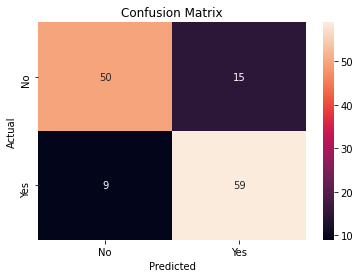

In [131]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels(['No', 'Yes'])

In [132]:
import pickle
import joblib
filename = 'loan_model.pkl'
joblib.dump(classifier, filename)

['loan_model.pkl']